# Neural Probabilistic Language Model

Vamos a construir un modelo probabilístico a partir de la arquitectura neuronal propuesta por Bengio (2003). En primer lugar, definimos las funciones necesarias para indexar las palabras en el corpus.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
#from preprocessing import preprocess
from itertools import chain

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

A partir de un corpus de cadenas, construimos el vocabulario indexado y las cadenas de índices.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10]]


A cada cadena le agregamos una etiqueta BOS (Beginning of String) y una etiqueta EOS (End of String). Se agregan al vocabulario y se indexan.

In [14]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

#Se obtiene la longitud del alfabeto
N = len(idx)

print(idx)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f80dc081ee0>, {'el': 0, 'perro': 1, 'come': 2, 'un': 3, 'hueso': 4, 'muchacho': 5, 'jugaba': 6, 'saltaba': 7, 'la': 8, 'cuerda': 9, 'croquetas': 10, '<EOS>': 13, '<BOS>': 14})


A partir de las cadenas se obtienen los bigramas

In [4]:
#Se crean los bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in cadenas]))

#Se obtiene la frecuencia de cada bigrama
frecBigrams = Counter(bigrams)

print(bigrams)

[(12, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 11), (12, 3), (3, 5), (5, 6), (6, 11), (12, 0), (0, 5), (5, 7), (7, 8), (8, 9), (9, 11), (12, 3), (3, 1), (1, 2), (2, 10), (10, 11)]


Ahora se inicializan los parámetros necesarios para entrenar el modelo.

In [5]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N
#El número de ejmplos
num_examples = len(bigrams)

#Dimensiones de los vectores-palabra
dim = 300
nn_hdim = 100

#Embedding
C = np.random.randn(dim,N) / np.sqrt(N)

#Capa oculta
U = np.random.randn(nn_hdim,dim) / np.sqrt(dim)
b = np.zeros((1, nn_hdim))

#Capa de salida
W = np.random.randn(N-1,nn_hdim) / np.sqrt(nn_hdim)
c = np.zeros((1, N-1))

Se entrena el modelo. Para esto, se define un número de iteraciones y un rango de aprendizaje. Se utiliza backpropagation y gradient descent.

In [6]:
its = 100
eta = 0.1
for i in range(0,its):
    for ex in bigrams:
        #Forward
        #Embedimiento
        c_w = C.T[ex[0]]
        #capa oculta
        h1 = np.tanh(np.dot(U,c_w) + b)[0]
        #salida
        out = np.exp(np.dot(W,h1) + c)[0]
        #Softmax
        f = out/out.sum(0)

        #Backprop
        #Variable de salida
        d_out = f
        d_out[ex[1]] -= 1
        
        #Variable para la capa oculta
        d_tanh = (1-h1**2)*np.dot(W.T,d_out)
        
        #Variable de embedding
        d_emb = np.dot(U.T,d_tanh)

        #Actualizacion de salida
        W -= eta*np.outer(d_out,h1)
        #Actualiza bias de salida
        c -= eta*d_out #[j]

        #Actualizacion de capa oculta
        U -= eta*np.outer(d_tanh,c_w)
        #Actualiza bias
        b -= eta*d_tanh

        #Actualizacion de embedding
        C.T[ex[0]] -= eta*d_emb


Ahora definirmos una función forward que va a obtener las probabilidades dada una palaba.

In [33]:
#Forward
def forward(x):    
    #Embedimiento
    c_w = C.T[x]
    #print c_w.shape, U.T.shape
    h1 = np.tanh(np.dot(U,c_w) + b)[0]
    #print h1 #W.shape, h1.shape
    out = np.exp(np.dot(W,h1) + c)[0]
    #print out
    p = out/out.sum(0)
    return p

Ahora que hemos entrenado el modelo, podemos obtener la probabilidad para cualquier par de palabras.

In [34]:
#p(muchacho|el)
print(forward(idx['el'])[idx['come']])

0.0007059253174156483


Los bigramas pocos frecuentes tendrán baja probabilidad.

In [9]:
#p(la|el)
print(forward(idx['el'])[idx['la']])

0.000875010814750372


Y podemos obtener todo el vector de probabilidades dada una palabra. Por ejemplo, para obtener el vector de probabilidades iniciales:

In [10]:
for word in idx.keys():
    if word != '<BOS>':
        print(word,forward(idx['<BOS>'])[idx[word]])

el 0.45026061279556845
perro 0.0009078171758437343
come 0.002067966673481341
un 0.5271298091543354
hueso 0.0004072343023013904
muchacho 0.0013439767221951164
jugaba 0.0016298505849492828
saltaba 0.0016255579738904998
la 0.001485555330490056
cuerda 0.0017501505776457392
croquetas 0.009628911811224916
<EOS> 0.0017625568980738748


Y podemos comprobar que se trata de una probabilidad, pues su suma es 1.

In [11]:
print(forward(idx['<BOS>']).sum(0))

0.9999999999999998


Ahora bien, una de las ventajas de este modelo es que tiene una capa de "embedding". En este sentido, las palabras quedan codificadas a partir de vectores en un espacio vectorial. Podemos ver cómo se comportan estos vectores.

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from operator import itemgetter

def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

Ahora ploteamos los vectores en un espacio de dos dimensiones.

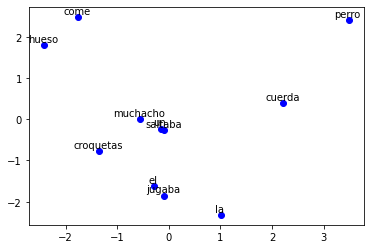

In [13]:
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]
plot_words(C.T[:-2],label[:-2])